# I- Corrélation entre attributs et suppression manuelle de quelques features


In [1]:
%pip install pandas


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72872 entries, 0 to 72871
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Num_Acc                   72872 non-null  int64  
 1   num_veh                   72872 non-null  int32  
 2   id_usa                    72872 non-null  int64  
 3   date                      72872 non-null  int64  
 4   ville                     72872 non-null  int32  
 5   id_code_insee             72872 non-null  int32  
 6   latitude                  72872 non-null  float64
 7   longitude                 72872 non-null  float64
 8   descr_cat_veh             72872 non-null  int64  
 9   descr_agglo               72872 non-null  int32  
 10  descr_athmo               72872 non-null  int32  
 11  descr_lum                 72872 non-null  int32  
 12  descr_etat_surf           72872 non-null  int32  
 13  description_intersection  72872 non-null  int32  
 14  an_nai

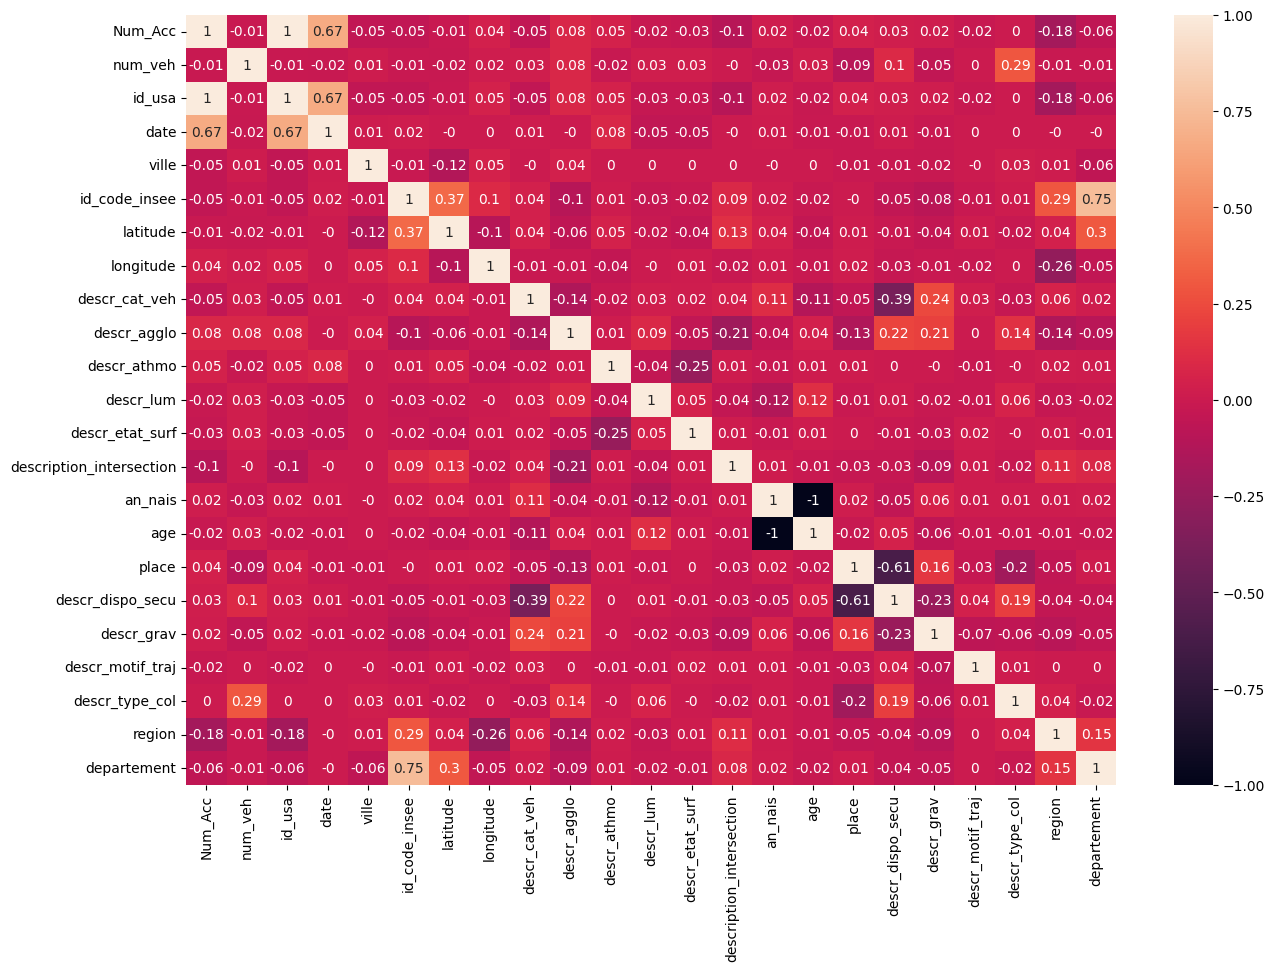

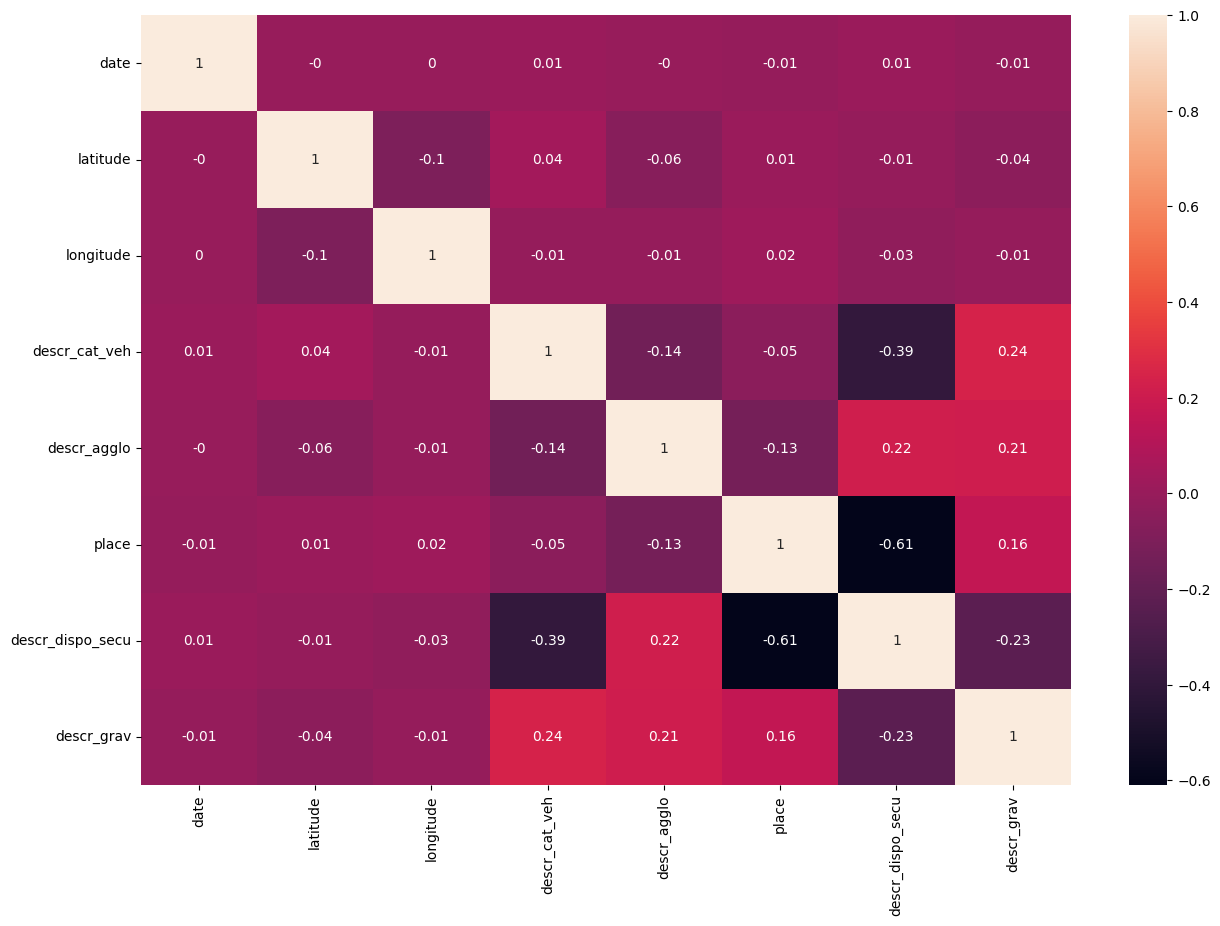

In [7]:
df = pd.read_csv('../df.csv')

enc = preprocessing.LabelEncoder()
#convertit en numérique les colonnes

for column_name in df:
    if column_name != 'longitude' and column_name != 'latitude':
        if not column_name.isnumeric()  :
            df[column_name] = enc.fit_transform(df[column_name])


df.info()
df
#matrice de correlation
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()

#supprimer colonne
del df['Num_Acc']
del df['num_veh']
del df['id_usa']
del df['ville']
del df['id_code_insee']
del df['descr_athmo']
del df['descr_lum']
del df['descr_etat_surf']
del df['description_intersection']
del df['an_nais']
del df['age']
del df['descr_motif_traj']
del df['descr_type_col']
del df['region']
del df['departement']

corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()
#del df['nom colonne']


# Partionnement ( Clustering )

## k-means from scikit-learn

c:\Users\ewann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


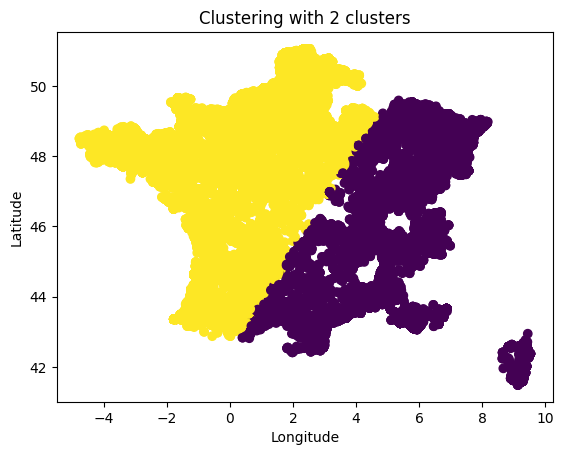

c:\Users\ewann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


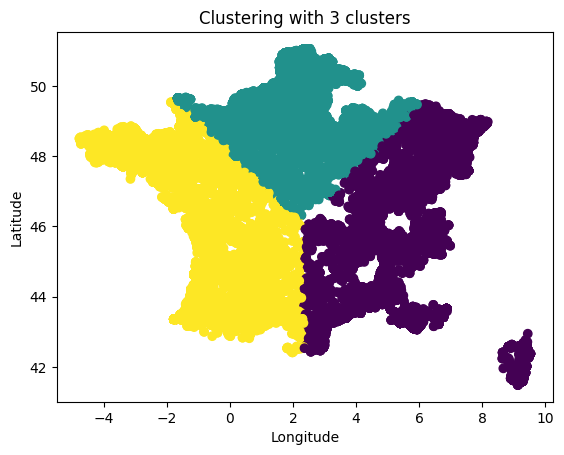

c:\Users\ewann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


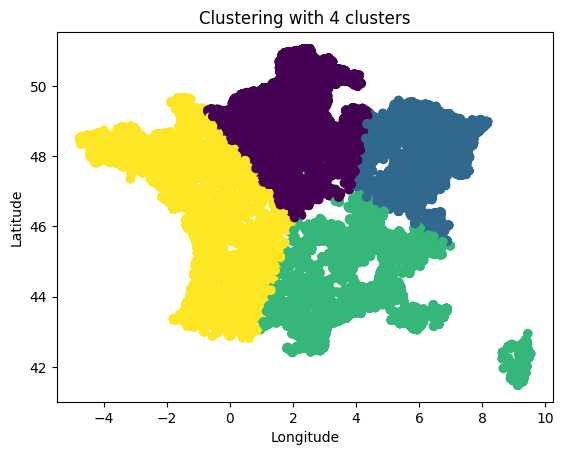

c:\Users\ewann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


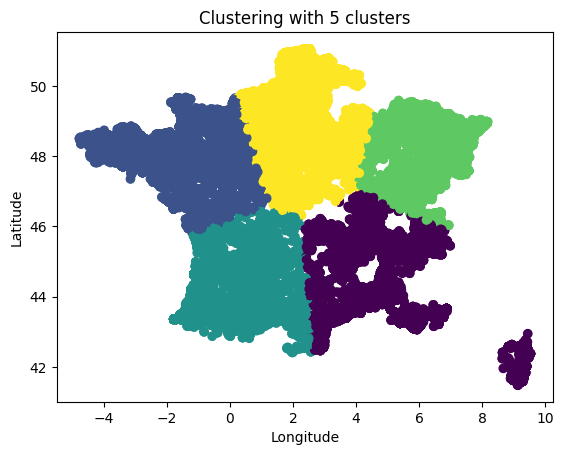

c:\Users\ewann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


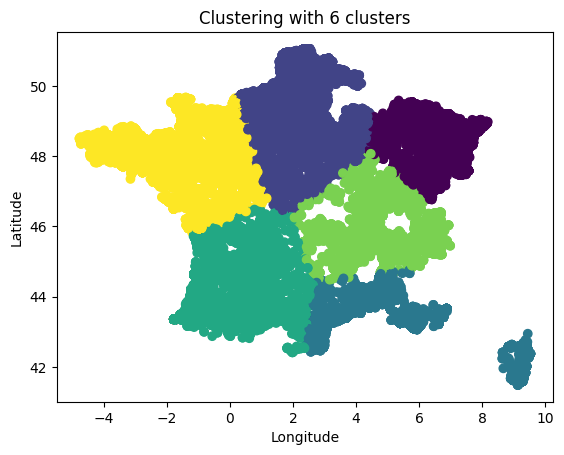

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger les données (latitude, longitude) dans un DataFrame
data = df[['latitude', 'longitude']]

# Liste des nombres de clusters à tester
n_clusters = [2, 3, 4, 5, 6]

# Effectuer le clustering pour chaque nombre de clusters
for n in n_clusters:
    # Instancier le modèle K-means
    kmeans = KMeans(n_clusters=n, random_state=42)
    
    # Effectuer le clustering
    kmeans.fit(data)
    
    # Assigner les clusters aux points de données
    labels = kmeans.labels_
    
    # Afficher le résultat du clustering
    plt.scatter(data['longitude'], data['latitude'], c=labels)
    plt.title(f"Clustering with {n} clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

## k-means from scratch

In [9]:
import matplotlib.pyplot as plt

In [10]:
from math import floor
import numpy as np


def naiveShard(df, k):
    
    n = df.shape[1]
    m = df.shape[0]
    centroidf = np.mat(np.zeros((k, n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(df.sum(axis=1))
    df = np.append(composite.T, df, axis=1)
    df.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m / k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shardf)
    # Sum columns of shardf, get means; these columnar means are centroidf
    for j in range(k):
        if j == k - 1:
            centroidf[j:] = vfunc(np.sum(df[j * step:, 1:], axis=0), step)
        else:
            centroidf[j:] = vfunc(np.sum(df[j * step:(j + 1) * step, 1:], axis=0), step)

    return centroidf

def _get_mean(sums, step):
    return sums / step


In [52]:
import sklearn.preprocessing

def Kmeans(NbCentroids,daf):
    clusterList = [[None]] * NbCentroids
    daf = daf[['latitude','longitude']]
    fig = plt.figure(figsize=(16,12))  # Width: 8 inches, Height: 6 inches
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    #on va utiliser la méthode par naive sharding
    minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_scaled = minmax_scaler.fit_transform(daf)
    centroids = naiveShard(X_scaled, k=NbCentroids)
    # Scale centroids using the same scaler
    centroids_scaled = minmax_scaler.inverse_transform(np.array(centroids))
    plt.scatter(centroids_scaled[:, 1], centroids_scaled[:, 0], c='red', marker='x')
    #pour chaque accident on regarde quel est le centroide le plus proche
    #daf = daf.loc[1]
    for index, row in daf.iterrows():
        pt = np.array([row['latitude'],row['longitude']])
        distlist = [None] * NbCentroids
        for i in range(len(centroids)):
            distlist[i] = np.linalg.norm(pt - centroids[i]) #dist eucl*
        min_index = distlist.index(min(distlist))
        clusterList[min_index].append(pt)
    plt.scatter(daf['longitude'],daf['latitude'],s=10)
    return clusterList
    


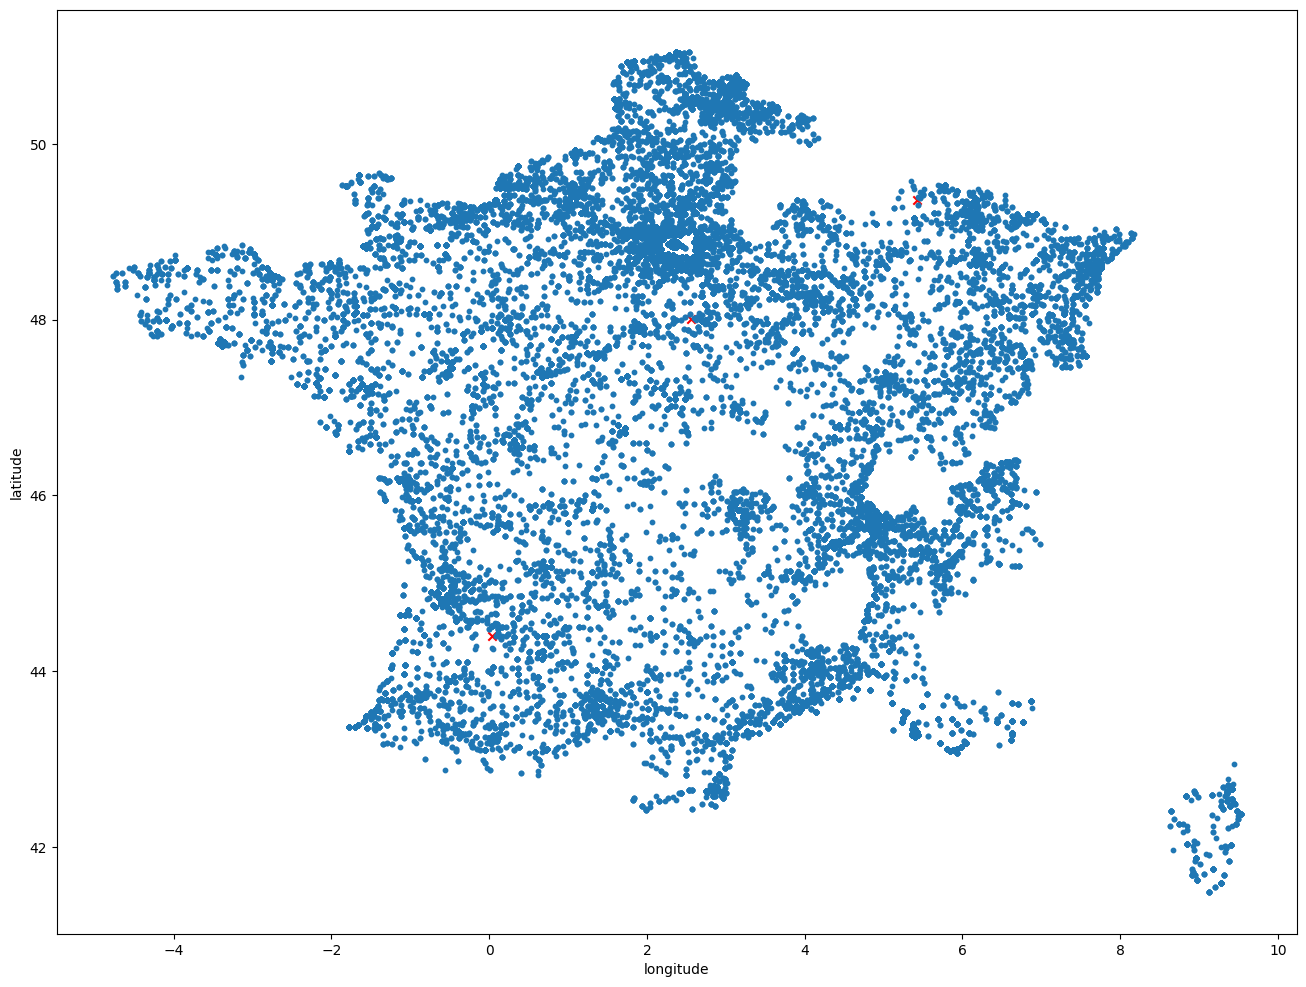

In [53]:
a = Kmeans(3,data)

In [65]:
yes = pd.DataFrame(a)
for index, row in yes.iterrows():
    print('>',index,'<')
    print(row)
    


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2266498682.py, line 4)

(apparté pour tester la méthode Naive SHarding)

si on l'adapte a notre code

le test avec nos données en pandas df

In [ ]:
import sklearn.preprocessing

# Scale dataset
minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = minmax_scaler.fit_transform(data)
centroids = naiveShard(X_scaled, 3)
print(centroids)


[[0.30480851 0.33569176]
 [0.68225776 0.5124189 ]
 [0.82374934 0.71279196]]
